In [28]:
from drn_interactions.interactions.loaders import SpontaneousActivityLoader
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.pairwise import PairwiseCorr, PairwisePartialCorr
from drn_interactions.interactions.popcup import PopulationCoupling
from drn_interactions.interactions.runners import InteractionsRunner
from drn_interactions.interactions.graph_clustering import df_to_graph, ClusterEvaluation, ClusterRunner, SpectralCluster
from drn_interactions.config import Config, ExperimentInfo
import numpy as np
from drn_interactions.interactions.graph import GraphAttributes, NodeAttributes
import pandas as pd
import seaborn as sns
from drn_interactions.io import load_derived_generic, load_distances, load_neurons
from drn_interactions.transforms.graph import GraphTransformer
import warnings

from scipy.stats import spearmanr
from ezbootstrap import bs_pairs
from sklearn.metrics import adjusted_mutual_info_score
import ezbootstrap as ez


def mean_se(x, round=2):
    return f"{np.round(x.mean(), round)}, {np.round(np.std(x), round)}"

In [4]:
first_half = (0, 900)
second_half = (900, 1800)
start_stops = (first_half, second_half)

In [5]:
# pairwise

neuron_types = load_derived_generic("neuron_types.csv")[
    ["neuron_id", "neuron_type", "session_name"]
]
sessions = neuron_types["session_name"].dropna().unique()
res_corr = []

loader_fac = lambda t_start, t_stop: SpontaneousActivityLoader(
    session_name=sessions[0], bin_width=1, shuffle=False, t_start=t_start, t_stop=t_stop
)
preprocessor_fac = lambda: InteractionsPreprocessor(
    z=True, minmax=False, gaussian_sigma=None
)
corr_fac = lambda: PairwiseCorr()

runner_fac = lambda t_start, t_stop: InteractionsRunner(
    loader=loader_fac(t_start=t_start, t_stop=t_stop),
    preprocessor=preprocessor_fac(),
    corr=corr_fac(),
)


for t_start, t_stop in start_stops:
    runner = runner_fac(t_start=t_start, t_stop=t_stop)
    res_corr.append(runner.run_corr_multi(sessions).assign(t_start=t_start))

rsc = (
    pd.concat(res_corr)
    .reset_index(drop=True)
    .rename(columns=dict(corr="value"))
    .assign(metric="rsc")
    .assign(mag=lambda x: np.abs(x["value"]))
)

In [6]:
# ensembles

sessions = load_neurons()["session_name"].dropna().unique()

preprocessor = InteractionsPreprocessor(
    z=True, 
    minmax=False
    )
evaluator = ClusterEvaluation()

loader_fac = lambda session, t_start, t_stop: SpontaneousActivityLoader(
    bin_width=1, session_name=session, shuffle=False, t_start=t_start, t_stop=t_stop
)
corr_fac = lambda: PairwiseCorr(
    remove_self_interactions=True,
    rectify=True,
    shuffle=False,
    remove_duplicate_combs=True,
)
cluster_fac = lambda: SpectralCluster(
    n_clusters=np.arange(2, 6), spectral_kws={"affinity": "precomputed"}, n_init=3
)

runner_fac = lambda session, t_start, t_stop: ClusterRunner(
    loader=loader_fac(session, t_start=t_start, t_stop=t_stop),
    preprocessor=preprocessor,
    affinity_calculator=corr_fac(),
    clusterer=cluster_fac(),
    evalulator=evaluator,
)


ensemble_frames = []
ensemble_stats_frames = []
current_max = 1
nboot = 5


for t_start, t_stop in start_stops:
    for session in sessions:
        runner = runner_fac(session, t_start=t_start, t_stop=t_stop)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            _, ensembles, _, ensemble_stats = runner.run(nboot)

        # update ensembles to global max
        ensembles["ensemble"] = np.where(
            ensembles["ensemble"] != -1, ensembles["ensemble"] + current_max, -1
        )
        ensemble_stats["ensemble"] = np.where(
            ensemble_stats["ensemble"] != -1,
            ensemble_stats["ensemble"] + current_max,
            -1,
        )
        current_max = ensembles["ensemble"].abs().max() + 1

        # add metadata and append to list of results
        ensembles = ensembles.assign(
            session_name=session, t_start=t_start,
        )
        ensemble_stats = ensemble_stats.assign(
            session_name=session, t_start=t_start,
        )
        ensemble_stats_frames.append(ensemble_stats)
        ensemble_frames.append(ensembles)


df_ensembles = pd.concat(ensemble_frames).reset_index(drop=True)
df_ensembles_stats = pd.concat(ensemble_stats_frames).reset_index(drop=True)

In [7]:
df_ens = df_ensembles.copy()

df_ens["ensemble_id"] = df_ens["ensemble"]
df_ens["in_ensemble"] = np.where(df_ens["ensemble_id"] == -1, False, True)

In [8]:
# graph

graph_attrs = GraphAttributes(inverse_distance=True)
node_attrs = NodeAttributes()

neuron_types = load_derived_generic("neuron_types.csv")[
    ["neuron_id", "neuron_type", "session_name"]
]
df_distance = load_distances()
sessions = neuron_types["session_name"].dropna().unique()

graph_dfs = []
node_dfs = []
edge_dfs = []

for t_start, t_stop in start_stops:
    g_transform = GraphTransformer(
        relabel_nodes=True,
        weight_attr="weight",
        neuron_types=neuron_types,
        df_distance=df_distance,
        df_ensemble=df_ens.loc[lambda x: x.t_start == t_start],
    )

    for session in sessions:
        loader = SpontaneousActivityLoader(
            session_name=session, bin_width=1, block="pre", t_start=t_start, t_stop=t_stop
        )
        preprocessor = InteractionsPreprocessor()
        pairwise = PairwiseCorr(rectify=True, shuffle=False)

        spikes = preprocessor(loader())
        df_affinity = (
            pairwise.fit(spikes)
            .get_adjacency_df()
            .dropna(axis=1, thresh=5)
            .dropna(axis=0, thresh=5)
        )
        G = df_to_graph(df_affinity, rename_nodes=True)
        graph_stats = graph_attrs.get_graph_attributes(G).assign(session=session, t_start=t_start)
        node_stats = node_attrs.get_node_attributes(G, node_name="neuron_id").assign(
            session=session, t_start=t_start
        )
        edge_stats =g_transform.graph_to_edge_df(G).assign(session=session, t_start=t_start)

        graph_dfs.append(graph_stats)
        node_dfs.append(node_stats)
        edge_dfs.append(edge_stats)

df_graph = pd.concat(graph_dfs).reset_index(drop=True)
df_node = pd.concat(node_dfs).reset_index(drop=True).merge(neuron_types[["neuron_id", "neuron_type"]], how="left")
df_node = df_node.merge(df_ens[["neuron_id", "in_ensemble", ]], how="left")
df_edge = pd.concat(edge_dfs).reset_index(drop=True)

#### Node Ensemble Status

In [32]:
df_mi = (
    df_ens
    .pivot(index=["session_name", "neuron_id"], columns="t_start", values="ensemble_id")
    .reset_index()
    .rename(columns={0: "first_half", 900: "second_half"})
    .dropna()
)

# obs = adjusted_mutual_info_score(df_mi["first_half"], df_mi["second_half"])
obs_reps = bs_pairs(
    df_mi["first_half"].values,
    df_mi["second_half"].values,
    adjusted_mutual_info_score,
    size=1000,
)


print(mean_se(obs_reps, round=2))

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\ezbootstrap\core.py:157: UserWarning: Numba compilation failed. Reverting to pure python
  warnings.warn("Numba compilation failed. Reverting to pure python")


0.55, 0.02


#### Node Degree

In [33]:
df_weight = (
    df_node
    [["session", "neuron_id", "t_start", "degree"]]
    .drop_duplicates()
    .pivot(index=["session", "neuron_id"], columns="t_start", values="degree")
    .reset_index()
    .rename(columns={0: "first_half", 900: "second_half"})
    .dropna()
)


# obs = spearmanr(df_weight["first_half"], df_weight["second_half"]).correlation
obs_reps = bs_pairs(
    df_weight["first_half"].values,
    df_weight["second_half"].values,
    lambda x, y: spearmanr(x, y).correlation,
    size=1000,
)

print(mean_se(obs_reps, round=2))

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\ezbootstrap\core.py:157: UserWarning: Numba compilation failed. Reverting to pure python
  warnings.warn("Numba compilation failed. Reverting to pure python")


0.5, 0.04


#### Node Clustering

In [34]:
df_clust = (
    df_node
    [["session", "neuron_id", "t_start", "clust"]]
    .drop_duplicates()
    .pivot(index=["session", "neuron_id"], columns="t_start", values="clust")
    .reset_index()
    .rename(columns={0: "first_half", 900: "second_half"})
    .dropna()
)


obs = spearmanr(df_clust["first_half"], df_clust["second_half"]).correlation
obs_reps = bs_pairs(
    df_clust["first_half"].values,
    df_clust["second_half"].values,
    lambda x, y: spearmanr(x, y).correlation,
    size=1000,
)

print(mean_se(obs_reps, round=2))

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\ezbootstrap\core.py:157: UserWarning: Numba compilation failed. Reverting to pure python
  warnings.warn("Numba compilation failed. Reverting to pure python")


0.43, 0.04


#### Edge Weight

In [35]:

df_weight = (
    df_edge
    [["session", "comb_id", "t_start", "weight"]]
    .drop_duplicates()
    .pivot(index=["session", "comb_id"], columns="t_start", values="weight")
    .reset_index()
    .rename(columns={0: "first_half", 900: "second_half"})
    .dropna()
)


obs_reps = bs_pairs(
    df_weight["first_half"].values,
    df_weight["second_half"].values,
    lambda x, y: spearmanr(x, y).correlation,
    size=1000,
)

print(mean_se(obs_reps, round=2))

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\ezbootstrap\core.py:157: UserWarning: Numba compilation failed. Reverting to pure python
  warnings.warn("Numba compilation failed. Reverting to pure python")


0.48, 0.01


#### Edge Ensemble Status

In [37]:
df_weight = (
    df_edge
    [["session", "comb_id", "t_start", "same_ensemble"]]
    .drop_duplicates()
    .pivot(index=["session", "comb_id"], columns="t_start", values="same_ensemble")
    .reset_index()
    .rename(columns={0: "first_half", 900: "second_half"})
    .dropna()
)


obs_reps = bs_pairs(
    df_weight["first_half"].values,
    df_weight["second_half"].values,
    adjusted_mutual_info_score,
    size=1000,
)
print(mean_se(obs_reps, round=2))

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\ezbootstrap\core.py:157: UserWarning: Numba compilation failed. Reverting to pure python
  warnings.warn("Numba compilation failed. Reverting to pure python")


0.01, 0.0


#### Edge Weight

In [38]:
df_weight = (
    df_edge
    [["session", "comb_id", "t_start", "weight"]]
    .drop_duplicates()
    .pivot(index=["session", "comb_id"], columns="t_start", values="weight")
    .reset_index()
    .rename(columns={0: "first_half", 900: "second_half"})
    .dropna()
)


obs_reps = bs_pairs(
    df_weight["first_half"].values,
    df_weight["second_half"].values,
    lambda x, y: spearmanr(x, y).correlation,
    size=1000,
)

print(mean_se(obs_reps, round=2))

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\ezbootstrap\core.py:157: UserWarning: Numba compilation failed. Reverting to pure python
  warnings.warn("Numba compilation failed. Reverting to pure python")


0.48, 0.01


In [125]:
df_ensembles.to_csv(
    Config.derived_data_dir / "ensembles_first_half_second_half.csv", index=False
)

## Example Figure

In [103]:
from drn_interactions.interactions.loaders import SpontaneousActivityLoader
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.pairwise import PairwiseCorr
from drn_interactions.interactions.graph_clustering import df_to_graph
import seaborn as sns
import matplotlib.pyplot as plt
from drn_interactions.io import load_derived_generic, load_distances
from drn_interactions.transforms.graph import GraphTransformer
from drn_interactions.transforms.spikes import SpikesHandler
from sklearn.preprocessing import minmax_scale, robust_scale
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.ndimage import gaussian_filter1d


def reorder_df_affinity(df, ensemble_labels):
    idx = np.argsort(ensemble_labels)
    return df.iloc[idx, idx]

def reorder_spikes(df, ensemble_labels):
    idx = np.argsort(ensemble_labels)
    return df.iloc[idx, :]


def get_affinity(session_name, t_start=0, t_stop=1800, rectify=True):
    loader = SpontaneousActivityLoader(session_name=session_name, t_start=t_start, t_stop=t_stop)
    preprocessor = InteractionsPreprocessor(z=True)
    mod = PairwiseCorr(rectify=rectify)

    spikes = preprocessor(loader())
    return mod.fit(spikes).get_adjacency_df()

def plot_affinity(df_affinity, ax, vmax=None, **kwargs):
    sns.heatmap(df_affinity, cmap="viridis", vmin=0, vmax=vmax, robust=True, ax=ax, **kwargs)
    return ax

def plot_spikes(spikes, ax, vmax=None, **kwargs):
    sns.heatmap(spikes, cmap="Greys", vmin=0, vmax=vmax, robust=True, ax=ax, **kwargs)
    return ax

def get_session_labels(df_ensembles, session_name):
    return df_ensembles.loc[lambda x: (x.session_name == session_name) & (x.t_start == 0)].sort_values("neuron_id")["ensemble"].values


def get_spikes(session_name, t_start=0, t_stop=1800):
    spikes = SpikesHandler(
        block="pre",
        bin_width=1,
        t_start=t_start,
        t_stop=t_stop,
        session_names=[session_name],
    ).binned_piv
    vals = TfidfTransformer().fit_transform(spikes).todense()
    spikes = pd.DataFrame(vals, columns=spikes.columns, index=spikes.index).apply(minmax_scale).T
    return spikes

In [89]:
sns.set_theme(style="ticks", context="paper")
fig_dir = Config.fig_dir

In [90]:
df_ensembles = pd.read_csv(Config.derived_data_dir / "ensembles_first_half_second_half.csv")
neuron_types = load_derived_generic("neuron_types.csv")
sessions = neuron_types["session_name"].unique()
print(sessions.tolist())

['ESHOCK_03_LOC1', 'ESHOCK_04_LOC1', 'ESHOCK_06_LOC1', 'ESHOCK_07_LOC1', 'ESHOCK_08_LOC1', 'ESHOCK_09_LOC1', 'hamilton_10', 'hamilton_03', 'hamilton_04', 'hamilton_09', 'hamilton_31', 'hamilton_38', nan, 'hamilton_37', 'hamilton_35', 'hamilton_36', 'hamilton_32', 'acute_15', 'acute_16', 'acute_01', 'acute_14', 'acute_12', 'acute_11']


In [107]:
session = "acute_15"

labs = get_session_labels(df_ensembles, session)
df_affinity_first_half = reorder_df_affinity(get_affinity(session, t_start=0, t_stop=900), labs)
df_affinity_second_half = reorder_df_affinity(get_affinity(session, t_start=900, t_stop=1800), labs)



(0.0, 30.0, 30.0, 0.0)

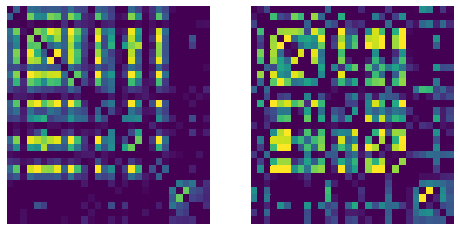

In [108]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))

plot_affinity(df_affinity_first_half, ax=ax[0], cbar=False)
ax[0].axis("off")
plot_affinity(df_affinity_second_half, ax=ax[1], cbar=False)
ax[1].axis("off")

Text(0.5, -3.3000000000000007, 'Time (min)')

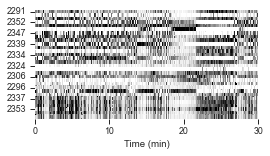

In [110]:
_, ax = plt.subplots(1, figsize=(4, 2))

spikes = get_spikes(session)
spikes = reorder_spikes(spikes, labs)
plot_spikes(spikes, ax=ax, cbar=False)

ax.set_xticks(np.arange(0, 1801, 600))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: int(x / 60)))
ax.set_ylabel("")
ax.set_xlabel("Time (min)")

In [68]:
get_session_labels(df_ensembles, session).unique()

array([34, 35], dtype=int64)

In [65]:
?get_session_labels

Signature: get_session_labels(df_ensembles, session_name)
Docstring: <no docstring>
File:      c:\users\roryl\repos\drn interactions\notebooks\spontaneous interactions\<ipython-input-47-61456d754b09>
Type:      function
